<a href="https://colab.research.google.com/github/SaloniJhalani/ImageClassificationOfBillionaires/blob/main/ImageClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install PyWavelets
!pip install opencv-python
!pip install seaborn

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
img = cv2.imread('./test_images/4.png')
print(img.shape)

(898, 902, 3)


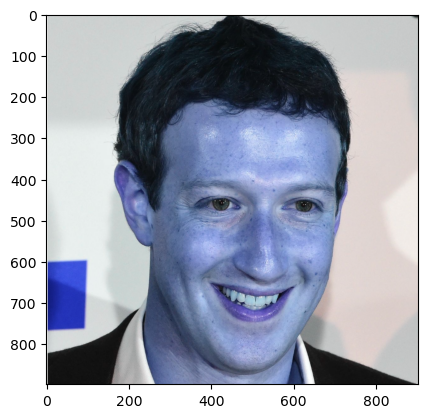

In [ ]:
plt.imshow(img)

In [ ]:
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
print(gray.shape)

(898, 902)


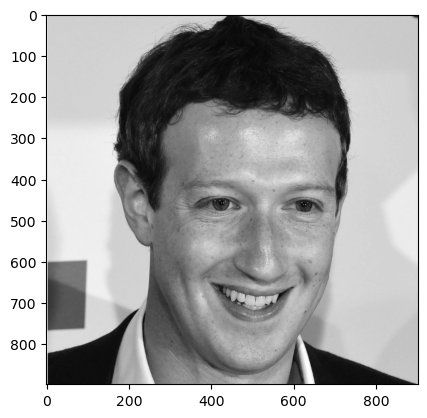

In [ ]:
plt.imshow(gray,cmap='gray')

In [ ]:
gray

array([[243, 243, 243, ...,  26,  30,  30],
       [243, 243, 243, ...,  28,  28,  28],
       [243, 243, 243, ...,  29,  29,  29],
       ...,
       [243, 243, 243, ..., 195, 195, 196],
       [243, 243, 243, ..., 195, 191, 198],
       [243, 243, 243, ..., 183, 187, 200]], dtype=uint8)

In [ ]:
#Face Detection using Haar Cascades
face_cascade = cv2.CascadeClassifier('./opencv/haarcascades/haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier('./opencv/haarcascades/haarcascade_eye.xml')

faces = face_cascade.detectMultiScale(gray, 1.3, 5)
faces

array([[239, 250, 573, 573]], dtype=int32)

In [ ]:
(x,y,w,h) = faces[0]
x,y,w,h

(239, 250, 573, 573)

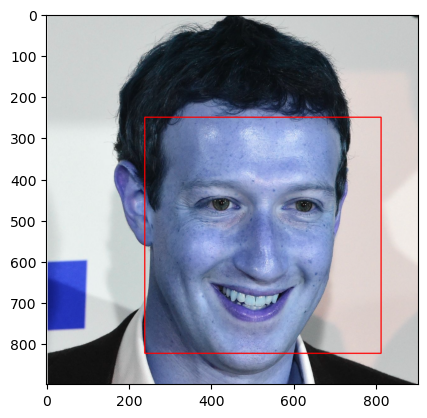

In [ ]:
face_img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
plt.imshow(face_img)

In [ ]:
cv2.destroyAllWindows()
count = 0
for (x,y,w,h) in faces:
    face_img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    roi_gray = gray[y:y+h, x:x+w]
    roi_color = face_img[y:y+h, x:x+w]
    eyes = eye_cascade.detectMultiScale(roi_gray)
    for (ex,ey,ew,eh) in eyes:
        cv2.rectangle(roi_color,(ex,ey),(ex+ew,ey+eh),(0,255,0),2)
        

plt.figure()
plt.imshow(face_img, cmap='gray')
plt.show()

In [ ]:
%matplotlib inline
plt.imshow(roi_color, cmap='gray')

In [ ]:
def get_cropped_image_if_2_eyes(image_path):
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    for (x,y,w,h) in faces:
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = img[y:y+h, x:x+w]
        eyes = eye_cascade.detectMultiScale(roi_gray)
        if len(eyes) >= 2:
            return roi_color

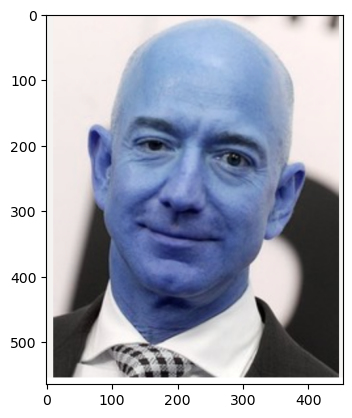

In [ ]:
original_image = cv2.imread('./test_images/1.png')
plt.imshow(original_image)

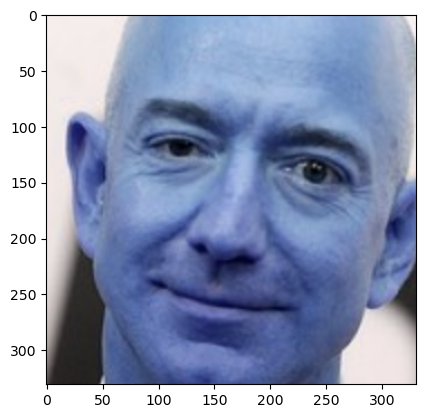

In [ ]:
cropped_image = get_cropped_image_if_2_eyes('./test_images/1.png')
plt.imshow(cropped_image)

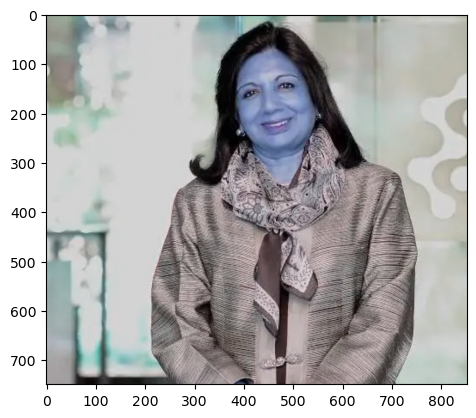

In [ ]:
org_image_obstructed = cv2.imread('./test_images/2.png')
plt.imshow(org_image_obstructed)

In [ ]:
cropped_image_no_2_eyes = get_cropped_image_if_2_eyes('./test_images/2.png')
cropped_image_no_2_eyes

array([[[ 17,  23,  22],
        [  0,   0,   0],
        [  9,  13,  13],
        ...,
        [ 39,  33,  32],
        [ 54,  48,  46],
        [ 83,  78,  75]],

       [[ 12,  16,  16],
        [  0,   3,   2],
        [  6,  10,   9],
        ...,
        [ 35,  29,  27],
        [ 44,  39,  37],
        [ 59,  54,  51]],

       [[  8,  11,  11],
        [  4,   6,   6],
        [  4,   7,   6],
        ...,
        [ 30,  25,  23],
        [ 36,  31,  28],
        [ 41,  36,  33]],

       ...,

       [[ 47,  42,  45],
        [ 56,  51,  53],
        [ 49,  44,  47],
        ...,
        [ 87,  80,  94],
        [130, 123, 136],
        [144, 138, 149]],

       [[ 50,  45,  48],
        [ 57,  52,  55],
        [ 53,  48,  50],
        ...,
        [108, 101, 115],
        [108, 101, 114],
        [ 99,  92, 104]],

       [[ 53,  48,  50],
        [ 59,  53,  56],
        [ 56,  51,  53],
        ...,
        [132, 125, 138],
        [ 96,  89, 101],
        [ 68,  62,  74]]

In [ ]:
path_to_data = "./dataset/"
path_to_cr_data = "./dataset/cropped/"

In [ ]:
import os
img_dirs = []
for entry in os.scandir(path_to_data):
    if entry.is_dir():
        img_dirs.append(entry.path)

In [ ]:
img_dirs

['./dataset/elon_musk',
 './dataset/kiran_mazumdar_shaw',
 './dataset/jeff_bezos',
 './dataset/mark_zuckerberg',
 './dataset/falguni_nayar']

In [ ]:
import shutil
if os.path.exists(path_to_cr_data):
     shutil.rmtree(path_to_cr_data)
os.mkdir(path_to_cr_data)

In [ ]:
cropped_image_dirs = []
celebrity_file_names_dict = {}

for img_dir in img_dirs:
    count = 1
    celebrity_name = img_dir.split('/')[-1]
    
    celebrity_file_names_dict[celebrity_name] = []
    
    for entry in os.scandir(img_dir):
        print(entry.path)
        roi_color = get_cropped_image_if_2_eyes(entry.path)
        if roi_color is not None:
            cropped_folder = path_to_cr_data + celebrity_name
            if not os.path.exists(cropped_folder):
                os.makedirs(cropped_folder)
                cropped_image_dirs.append(cropped_folder)
            cropped_file_name = celebrity_name + str(count) + ".png"
            cropped_file_path = cropped_folder + "/" + cropped_file_name 
            
            cv2.imwrite(cropped_file_path, roi_color)
            celebrity_file_names_dict[celebrity_name].append(cropped_file_path)
            count += 1    

In [ ]:
celebrity_file_names_dict = {}
for img_dir in cropped_image_dirs:
    celebrity_name = img_dir.split('/')[-1]
    file_list = []
    for entry in os.scandir(img_dir):
        file_list.append(entry.path)
    celebrity_file_names_dict[celebrity_name] = file_list
celebrity_file_names_dict

In [ ]:
#Wavelet Transform
import numpy as np
import pywt
import cv2    

def w2d(img, mode='haar', level=1):
    imArray = img
    #Datatype conversions
    #convert to grayscale
    imArray = cv2.cvtColor( imArray,cv2.COLOR_RGB2GRAY )
    #convert to float
    imArray =  np.float32(imArray)   
    imArray /= 255;
    # compute coefficients 
    coeffs=pywt.wavedec2(imArray, mode, level=level)

    #Process Coefficients
    coeffs_H=list(coeffs)  
    coeffs_H[0] *= 0;  

    # reconstruction
    imArray_H=pywt.waverec2(coeffs_H, mode);
    imArray_H *= 255;
    imArray_H =  np.uint8(imArray_H)

    return imArray_H

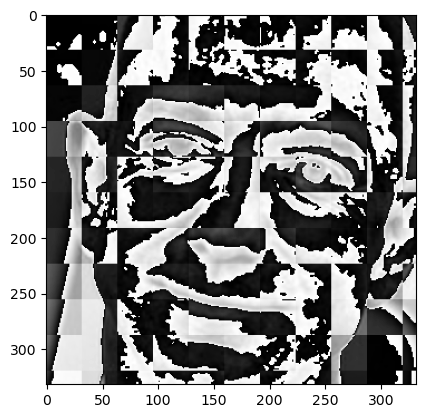

In [ ]:
im_har = w2d(cropped_image,'db1',5)
plt.imshow(im_har, cmap='gray')

In [ ]:
class_dict = {}
count = 0
for celebrity_name in celebrity_file_names_dict.keys():
    class_dict[celebrity_name] = count
    count = count + 1
class_dict

{'elon_musk': 0,
 'kiran_mazumdar_shaw': 1,
 'jeff_bezos': 2,
 'mark_zuckerberg': 3,
 'falguni_nayar': 4}

In [ ]:
X, y = [], []
for celebrity_name, training_files in celebrity_file_names_dict.items():
    for training_image in training_files:
        img = cv2.imread(training_image)
        if img is None:
            continue
        scalled_raw_img = cv2.resize(img, (32, 32))
        img_har = w2d(img,'db1',5)
        scalled_img_har = cv2.resize(img_har, (32, 32))
        combined_img = np.vstack((scalled_raw_img.reshape(32*32*3,1),scalled_img_har.reshape(32*32,1)))
        X.append(combined_img)
        y.append(class_dict[celebrity_name])   

In [ ]:
X[0].shape

(4096, 1)

In [ ]:
len(X)

349

In [ ]:
X = np.array(X).reshape(len(X),4096).astype(float)
X.shape

(349, 4096)

In [ ]:
#SVM

In [ ]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=6,test_size=0.2)

pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC(kernel = 'rbf', C = 10))])
pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

0.8142857142857143

In [ ]:
print(classification_report(y_test, pipe.predict(X_test)))

              precision    recall  f1-score   support

           0       0.81      0.87      0.84        15
           1       0.92      1.00      0.96        11
           2       0.76      0.86      0.81        22
           3       0.75      0.60      0.67        15
           4       1.00      0.71      0.83         7

    accuracy                           0.81        70
   macro avg       0.85      0.81      0.82        70
weighted avg       0.82      0.81      0.81        70



In [ ]:
class_dict

{'elon_musk': 0,
 'kiran_mazumdar_shaw': 1,
 'jeff_bezos': 2,
 'mark_zuckerberg': 3,
 'falguni_nayar': 4}

In [ ]:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

In [ ]:
model_params = {
    'svm': {
        'model': svm.SVC(gamma='auto',probability=True),
        'params' : {
            'svc__C': [1,10,100,1000],
            'svc__kernel': ['rbf','linear']
        }  
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'randomforestclassifier__n_estimators': [1,5,10]
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear',multi_class='auto'),
        'params': {
            'logisticregression__C': [1,5,10]
        }
    }
}

In [ ]:
scores = []
best_estimators = {}
import pandas as pd
for algo, mp in model_params.items():
    pipe = make_pipeline(StandardScaler(), mp['model'])
    clf =  GridSearchCV(pipe, mp['params'], cv=5, return_train_score=False)
    clf.fit(X_train, y_train)
    scores.append({
        'model': algo,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    best_estimators[algo] = clf.best_estimator_
    
df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df


,model,best_score,best_params
0,svm,0.799221,"{'svc__C': 1, 'svc__kernel': 'linear'}"
1,random_forest,0.613052,{'randomforestclassifier__n_estimators': 10}
2,logistic_regression,0.806299,{'logisticregression__C': 1}


In [ ]:
best_estimators

{'svm': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('svc',
                  SVC(C=1, gamma='auto', kernel='linear', probability=True))]),
 'random_forest': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('randomforestclassifier',
                  RandomForestClassifier(n_estimators=10))]),
 'logistic_regression': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('logisticregression',
                  LogisticRegression(C=1, solver='liblinear'))])}

In [ ]:
best_estimators['svm'].score(X_test,y_test)

0.8571428571428571

In [ ]:
best_estimators['random_forest'].score(X_test,y_test)

0.6

In [ ]:
best_estimators['logistic_regression'].score(X_test,y_test)

0.8571428571428571

In [ ]:
best_clf = best_estimators['svm']

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, best_clf.predict(X_test))
cm

array([[13,  0,  2,  0,  0],
       [ 0, 11,  0,  0,  0],
       [ 1,  0, 19,  1,  1],
       [ 0,  0,  3, 12,  0],
       [ 0,  1,  1,  0,  5]])

Text(95.72222222222221, 0.5, 'Truth')

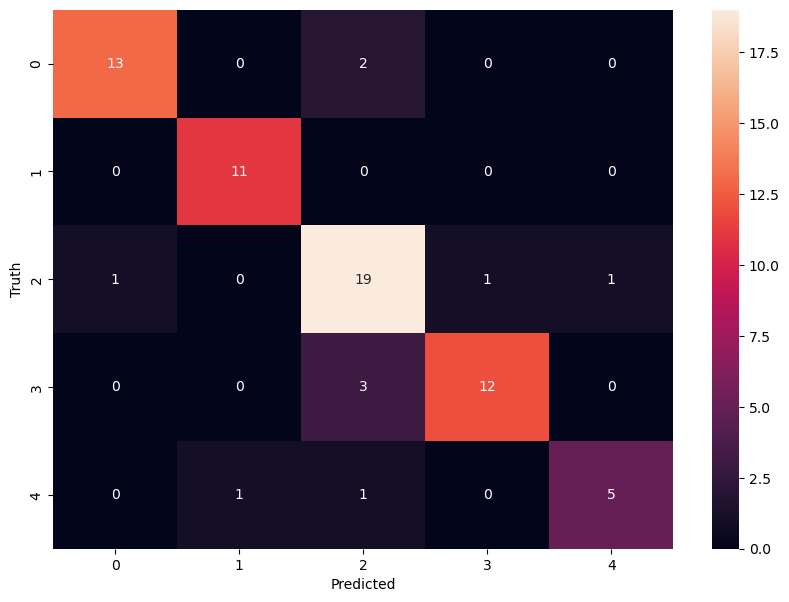

In [ ]:
import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [ ]:
class_dict

{'elon_musk': 0,
 'kiran_mazumdar_shaw': 1,
 'jeff_bezos': 2,
 'mark_zuckerberg': 3,
 'falguni_nayar': 4}

In [ ]:
!pip install joblib
import joblib 
# Save the model as a pickle in a file 
joblib.dump(best_clf, 'saved_model.pkl') 

['saved_model.pkl']

In [ ]:
import json
with open("class_dictionary.json","w") as f:
    f.write(json.dumps(class_dict))